# Scalar Grad Dev and Demo

In [1]:
%load_ext autoreload
%autoreload 2
%config IPCompleter.greedy=True

import pdb, sys, warnings, os, json, math
warnings.filterwarnings(action='ignore')

from IPython.display import display, HTML

import numpy as np
from graphviz import Digraph
import matplotlib.pyplot as plt
import seaborn as sns

np.set_printoptions(precision=4)
sns.set_style("darkgrid")
%matplotlib inline

## Functions

In [2]:
def trace(root):
  """
  Builds a set of all nodes and edges in a graph
  """
  nodes,edges = set(),set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v.prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes,edges

def draw_dot(root, format='svg', rankdir='LR', show_backprop=True, colors=True):
  """
  format: png | svg | ...
  rankdir: TB (top to bottom graph) | LR (left to right)
  """
  assert rankdir in ['LR', 'TB']
  nodes,edges = trace(root)
  dot = Digraph(format=format, graph_attr={'rankdir': rankdir, 'ordering': 'in'}, engine='dot')
  edge_color = 'blue' if colors else 'black'
  node_color = 'purple' if colors else 'black'
  
  for n in nodes:
    if hasattr(n, 'grad_updated') and n.grad_updated:
      deri = f'({n.label})' if len(n.label) > 2 else n.label
      dot.node(name=str(id(n)), label = '{%s|%.3f}|{do/d%s|%.3f}' % (n.label,n.data,deri,n.grad), shape='record', color=edge_color)
    else:
      dot.node(name=str(id(n)), label = '{%s|%.3f}' % (n.label,n.data), shape='record')
    
    if n.op:
      if hasattr(n, 'grad_updated') and n.grad_updated:
        dot.node(name=f'{str(id(n))}{n.op}', label=n.op, color=node_color)
      else:
        dot.node(name=f'{str(id(n))}{n.op}', label=n.op)
      dot.edge(f'{str(id(n))}{n.op}', str(id(n)))
      
  for n1,n2 in edges:
    dot.edge(str(id(n1)), f'{str(id(n2))}{n2.op}')
  
  if show_backprop:
    if hasattr(n, 'grad_updated'):
      for n1, n2 in edges:
        if n2.grad != 0:
          dot.edge(str(id(n1)), f'{str(id(n2))}', color='red', style='dashed', dir='back')
  
  return dot

## What is a derivative?

1. Define `f(x)` and show some values. Its a quadric equation so its a parabola.
2. Plot it with `xs = np.arange(-5, 5, 0.25)` and get `ys` with `f(xs)`
3. What is the derivative at each point? Solving with calculus with formulas...but
4. we are doing it using first principles

In [3]:
def f(x):
  return 3*x**2 - 4*x + 5

In [4]:
xs  = np.arange(-5, 5, 0.25)
ys = f(xs)

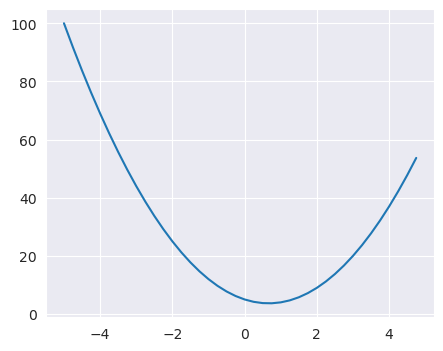

In [5]:
fig, ax = plt.subplots(1,1,figsize=(5, 4))
ax.plot(xs, ys)

In [6]:
h = 0.000001

In [7]:
x = 3.0
(f(x + h) - f(x)) / h

14.000003002223593

In [8]:
x = -3.0
(f(x + h) - f(x)) / h

-21.999997002808414

In [9]:
x = -3.0
(f(x + h) - f(x)) / h

-21.999997002808414

In [10]:
x = 2/3
(f(x + h) - f(x)) / h

2.999378523327323e-06

## Partial derivatives with multiple variables

1. Define a simple expression with 3 variables `d = a*b + c` and get the partial derivatives
2. We will go into NN's net

In [11]:
h = 0.000001

In [12]:
a = 2.0
b = -3.0
c = 10.0
d1 = a*b + c

c += h
d2 = a*b + c

print(f'{d1 = }')
print(f'{d2 = }')
print(f'{(d2-d1)/h = }')

d1 = 4.0
d2 = 4.000000999999999
(d2-d1)/h = 0.9999999992515995


## Class Dev - Manual Backprop

### Forward Pass

1. Barebones `Scalar` class with just data
2. Add the dunder methods for arithmetics
3. We want to keep *expression graphs*, so we need to know and keep pointers of what `Scalar` produce other `Scalar`
4. Add `_children` tuple and modify dunder methods
5. What operation created the `Scalar`? Add `_op` attribute
6. Give the scalar a name
7. Draw computational graph
8. More complex expression with more variables

In [13]:
class Scalar(object):
  """
  Stores a single scalar value and its attributes
  """
  
  def __init__(self, data, children=(), op='', label=''):
    self._data = data
    self.prev = set(children)
    self.op = op
    self.label = label
    
  @property 
  def data(self):
    return self._data
  
  @data.setter
  def data(self, val):
    self._data = val
    
  def __add__(self, other):
    return Scalar(self._data + other._data, (self, other), '+')
  
  def __mul__(self, other):
    return Scalar(self._data * other._data, (self, other), '*')
  
  def __repr__(self):
    return f"Scalar(data={self._data})"

In [14]:
a = Scalar(2.0, label='a')
b = Scalar(-3.0, label='b')
c = Scalar(10.0, label='c')
d = a*b; d.label = 'd'
e = d+c; e.label = 'e'
f = Scalar(-2.0, label='f')
o = e*f; o.label = 'o'
o

Scalar(data=-8.0)

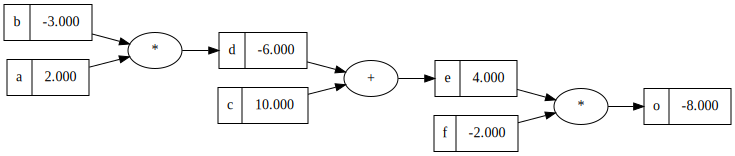

In [15]:
draw_dot(o)

### Backward Pass
1. We are going to backpropagate through the graph by computing the derivative of that node w.r.t. to output L
2. Derivative of L w.r.t. L is just 1
3. In NN setting, L would be the loss function and everything except a and b are the parameters (weights)
4. How the weights impact the loss function?
5. Since the data is fixed, we don't necessarily care about the derivative of the loss w.r.t. data (exception adversarial ML where we want to manipulate the data to impact the loss ie fgsm)

1. Maintain the gradient variable
2. Numerical gradient in foo function
3. l,e,f backprop
4. Most important gradient: understanding this => understanding all of backprop
5. Calculate the *local* derivative
6. CHAIN RULE for global derivative

In [16]:
class Scalar(object):
  """
  Stores a single scalar value and its attributes
  """
  
  def __init__(self, data, children=(), op='', label=''):
    self._data = data
    self._grad = 0.0
    self.grad_updated = False    
    self.prev = set(children)
    self.op = op
    self.label = label
    
  @property 
  def data(self):
    return self._data
  
  @data.setter
  def data(self, val):
    self._data = val
    
  @property 
  def grad(self):
    return self._grad
  
  @grad.setter
  def grad(self, val):
    self.grad_updated = True
    self._grad = val
    
  def __add__(self, other):
    return Scalar(self._data + other._data, (self, other), '+')
  
  def __mul__(self, other):
    return Scalar(self._data * other._data, (self, other), '*')
  
  def __repr__(self):
    return f"Scalar(data={self._data})"

In [17]:
a = Scalar(2.0, label='a')
b = Scalar(-3.0, label='b')
c = Scalar(10.0, label='c')
d = a*b; d.label = 'd'
e = d+c; e.label = 'e'
f = Scalar(-2.0, label='f')
o = e*f; o.label = 'o'
o

Scalar(data=-8.0)

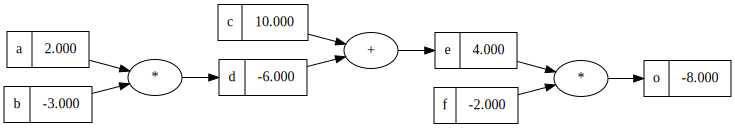

In [18]:
draw_dot(o)

`+` just *routes* the gradient

In [19]:
o.grad = 1.0

In [20]:
e.grad = f.data
f.grad = e.data

In [21]:
c.grad = e.grad * 1.0
d.grad = e.grad * 1.0

In [22]:
a.grad = (-2.0) * -3.0
b.grad = (-2.0) * 2

Lets nudge the leaf nodes (that we have influence over) and re-run the forward pass (over ops we don't have influence over) and print out the loss

In [23]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

d = a*b; d.label = 'd'
e = d+c; e.label = 'e'
o = e*f; o.label = 'o'
o

Scalar(data=-7.286496)

In [24]:
def foo():
  h = 0.000001
  
  a = Scalar(2.0, label='a')
  b = Scalar(-3.0, label='b')
  c = Scalar(10.0, label='c')
  d = a*b; d.label = 'd'
  e = d+c; e.label = 'e'
  f = Scalar(-2.0, label='f')
  o = e*f; o.label = 'o'
  o1 = o.data
  
  a = Scalar(2.0, label='a')
  b = Scalar(-3.0, label='b')
  b.data+=h
  c = Scalar(10.0, label='c')
  d = a*b; d.label = 'd'
  e = d+c; e.label = 'e'
  f = Scalar(-2.0, label='f')
  o = e*f; o.label = 'o'
  o2 = o.data
  
  print((o2-o1)/h)

foo()

-4.000000000559112


### Manual Backprop with a neuron

1. Neurons have inputs `x` and weights `w`
2. `w*x` is the input to the neuron with a bias which will be adjusted to either fire the neuron or not
3. Activation function to squash the inputs to some range, we are using `tanh`
4. Activation function takes in the dot products of its inputs

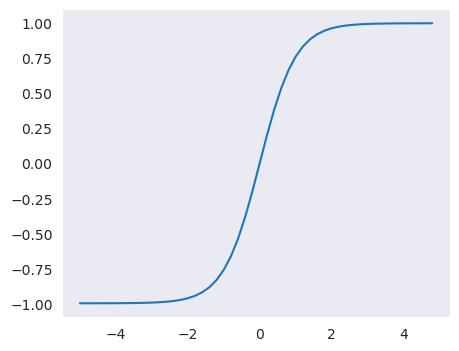

In [25]:
fig,ax = plt.subplots(1,1,figsize=(5,4))
ax.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2)))
ax.grid()

In [26]:
class Scalar(object):
  """
  Stores a single scalar value and its attributes
  """
  
  def __init__(self, data, children=(), op='', label=''):
    self._data = data
    self._grad = 0.0
    self.grad_updated = False    
    self.prev = set(children)
    self.op = op
    self.label = label
    
  @property 
  def data(self):
    return self._data
  
  @data.setter
  def data(self, val):
    self._data = val
    
  @property 
  def grad(self):
    return self._grad
  
  @grad.setter
  def grad(self, val):
    self.grad_updated = True
    self._grad = val
    
  def __add__(self, other):
    return Scalar(self._data + other._data, (self, other), '+')
  
  def __mul__(self, other):
    return Scalar(self._data * other._data, (self, other), '*')
  
  def tanh(self):
    n = self._data
    t = (np.exp(2*n)-1)/(np.exp(2*n)+1)
    return Scalar(t, (self, ), 'tanh')
  
  def __repr__(self):
    return f"Scalar(data={self._data})"

Change bias to `6.8813735870195432` for backprop

In [27]:
# inputs
x1 = Scalar(2.0, label='x1')
x2 = Scalar(0.0, label='x2')

# weights
w1 = Scalar(-3.0, label='w1')
w2 = Scalar(1.0, label='w2')

# bias
b = Scalar(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

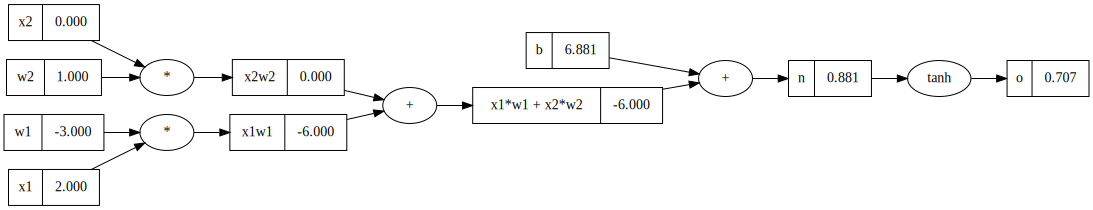

In [28]:
draw_dot(o)

1. Derivative of `tanh` is `1-tanh^2`
2. `x2` has no influence on output since gradient is zero

In [29]:
o.grad = 1.0

In [30]:
n.grad = 1 - o.data**2

In [31]:
x1w1x2w2.grad = n.grad
b.grad = n.grad

In [32]:
x1w1.grad = x1w1x2w2.grad
x2w2.grad = x1w1x2w2.grad

In [33]:
x2.grad = w2.data * x2w2.grad
w2.grad = (x2.data * x2w2.grad)

x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

### Automatic backprop

1. Backward func by default doesn't do anything and will do the little piece of chain rule. Leaf code has nothing to do

In [34]:

class Scalar(object):
  """
  Stores a single scalar value and its attributes
  """
  
  def __init__(self, data, children=(), op='', label=''):
    self._data = data
    self._grad = 0.0
    self._backward = lambda: None
    self.grad_updated = False    
    self.prev = set(children)
    self.op = op
    self.label = label
    
  @property 
  def data(self):
    return self._data
  
  @data.setter
  def data(self, val):
    self._data = val
    
  @property 
  def grad(self):
    return self._grad
  
  @grad.setter
  def grad(self, val):
    self.grad_updated = True
    self._grad = val
    
  def __add__(self, other):
    out = Scalar(self._data + other._data, (self, other), '+')
    def _backward():
      self.grad = 1.0 * out.grad
      other.grad = 1.0 * out.grad   
    out._backward = _backward
    return out
  
  def __mul__(self, other):
    out = Scalar(self._data * other.data, (self, other), '*')
    def _backward():
      self.grad = other._data * out.grad
      other.grad = self._data * out.grad
    out._backward = _backward
    return out
  
  def tanh(self):
    n = self._data
    t = (np.exp(2*n)-1)/(np.exp(2*n)+1)
    out = Scalar(t, (self, ), 'tanh') 
    def _backward():
      self.grad = (1 - t**2) * out.grad
    out._backward = _backward
    return out
  
  def __repr__(self):
    return f"Scalar(data={self._data})"

In [35]:
# inputs
x1 = Scalar(2.0, label='x1')
x2 = Scalar(0.0, label='x2')

# weights
w1 = Scalar(-3.0, label='w1')
w2 = Scalar(1.0, label='w2')

# bias
b = Scalar(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = '(x1*w1 + x2*w2)'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

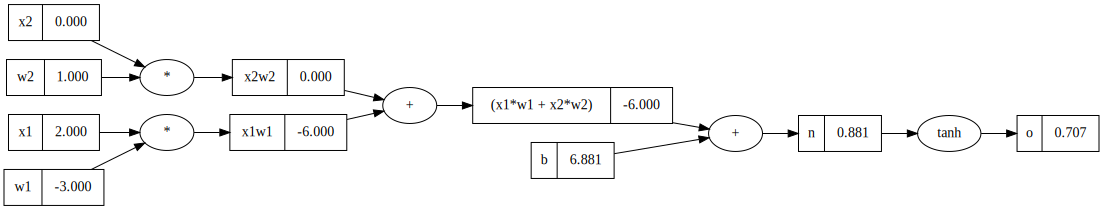

In [36]:
draw_dot(o)

In [37]:
o.grad = 1.0
o._backward()

In [38]:
n._backward()

In [39]:
b._backward()

In [40]:
x1w1x2w2._backward()

In [41]:
x1w1._backward()
x2w2._backward()

### Automatic backprop with one function call with Topo sort

In [42]:

class Scalar(object):
  """
  Stores a single scalar value and its attributes
  """
  
  def __init__(self, data, children=(), op='', label=''):
    self._data = data
    self._grad = 0.0
    self._backward = lambda: None
    self.grad_updated = False    
    self.prev = set(children)
    self.op = op
    self.label = label
    
  @property 
  def data(self):
    return self._data
  
  @data.setter
  def data(self, val):
    self._data = val
    
  @property 
  def grad(self):
    return self._grad
  
  @grad.setter
  def grad(self, val):
    self.grad_updated = True
    self._grad = val
    
  def __add__(self, other):
    out = Scalar(self._data + other._data, (self, other), '+')
    def _backward():
      self.grad = 1.0 * out.grad
      other.grad = 1.0 * out.grad   
    out._backward = _backward
    return out
  
  def __mul__(self, other):
    out = Scalar(self._data * other.data, (self, other), '*')
    def _backward():
      self.grad = other._data * out.grad
      other.grad = self._data * out.grad
    out._backward = _backward
    return out
  
  def tanh(self):
    n = self._data
    t = (np.exp(2*n)-1)/(np.exp(2*n)+1)
    out = Scalar(t, (self, ), 'tanh') 
    def _backward():
      self.grad = (1 - t**2) * out.grad
    out._backward = _backward
    return out
  
  def backward(self):
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v.prev:
          build_topo(child)
        topo.append(v)
        
    build_topo(self)    
    self._grad = 1.0
    for node in reversed(topo):
      node._backward()
 
  def __repr__(self):
    return f"Scalar(data={self._data})"

In [43]:
# inputs
x1 = Scalar(2.0, label='x1')
x2 = Scalar(0.0, label='x2')

# weights
w1 = Scalar(-3.0, label='w1')
w2 = Scalar(1.0, label='w2')

# bias
b = Scalar(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = '(x1*w1 + x2*w2)'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

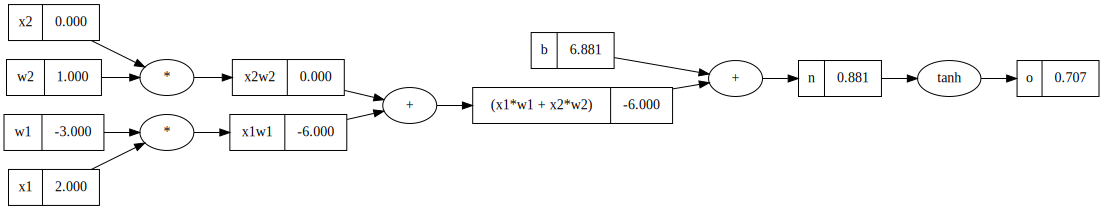

In [44]:
draw_dot(o, show_backprop=False)

In [45]:
o.backward()

In [46]:
# topo = []
# visited = set()
# def build_topo(v):
#   if v not in visited:
#     visited.add(v)
#     for child in v.prev:
#       build_topo(child)
#     topo.append(v)
# build_topo(o)    
# print(topo)

# o.grad = 1.0
# for node in reversed(topo):
#   node._backward()

There is an issue when a variable used more than once. Gradients are overwritten. To remedy this, instead of setting the gradients they need to be accumulated with `+=`. So any contribution flowing backward will simply add.

In [47]:
# a = Scalar(3.0, label='a')
# o = a + a; o.label = 'o'
# o.backward()
# draw_dot(o, show_backprop=False)

In [48]:
# a = Scalar(-2.0, label='a')
# b = Scalar(3.0, label='b')
# d = a*b; d.label='d'
# e = a+b; e.label='e'
# o = d*e; o.label='f'
# o.backward()
# draw_dot(o, show_backprop=False)

## Breaking up tanh with more operations

1. Decorator to check instance of `other`
2. `r_op` (like `rmul`) for right operation
3. Decorator for `2+a`
4. Implement `exp`, `pow`, and `div`

In [49]:
def scalarize(func):
  #this is the key line. There's the aditional self parameter
  def inner(self, *args, **kwargs):    
    other = args[0] if isinstance(args[0], Scalar) else Scalar(args[0])
    # you can use self here as if you were inside the class
    return func(self, other)
  return inner


class Scalar(object):
  """
  Stores a single scalar value and its attributes
  """
  
  def __init__(self, data, children=(), op='', label=''):
    self._data = data
    self._grad = 0.0
    self._backward = lambda: None
    self.grad_updated = False    
    self.prev = set(children)
    self.op = op
    self.label = label
    
  @property
  def data(self):
    return self._data
  
  @data.setter
  def data(self, val):
    self._data = val
    
  @property 
  def grad(self):
    return self._grad
  
  @grad.setter
  def grad(self, val):
    self.grad_updated = True
    self._grad = val
    
  @scalarize
  def __add__(self, other):
    # other = other if isinstance(args[0], Scalar) else Scalar(other)
    out = Scalar(self._data + other._data, (self, other), '+')
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad   
    out._backward = _backward
    return out
  
  def __radd__(self, other):
    return self + other
  
  def __neg__(self):
    out = self * -1
    out.op = 'neg'
    return out  
  
  def __sub__(self, other):
    out = self + (-other) 
    out.op = '-'
    return out
  
  def __rsub__(self, other):
    return other + (-self)  
  
  @scalarize
  def __mul__(self, other):
    out = Scalar(self._data * other._data, (self, other), '*')
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
    return out 
  
  def __rmul__(self, other):
    return self * other
  
  def __truediv__(self, other):
    out = self * other**-1
    out.op = '/'
    return out
  
  def __rtruediv__(self, other):
    return other * self**-1
  
  def __pow__(self, other):
    assert isinstance(other, (int, float)), "Only supporting int/float for now"
    out = Scalar(self._data**other, (self, ), f'^{other}')    
    def _backward():
      self.grad += (other * self._data**(other - 1)) * out.grad      
    out._backward = _backward
    return out
  
  def exp(self):
    out = Scalar(np.exp(self._data), (self,), 'exp')
    def _backward():
      self.grad += out._data * out.grad
    out._backward = _backward
    return out  
  
  def tanh(self):
    n = self._data
    t = (np.exp(2*n)-1)/(np.exp(2*n)+1)
    out = Scalar(t, (self, ), 'tanh') 
    def _backward():
      self.grad = (1 - t**2) * out.grad
    out._backward = _backward
    return out
  
  def backward(self):
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v.prev:
          build_topo(child)
        topo.append(v)
        
    build_topo(self)    
    self._grad = 1.0
    for node in reversed(topo):
      node._backward()
 
  def __repr__(self):
    return f"Scalar(data={self._data})"

In [50]:
# inputs
x1 = Scalar(2.0, label='x1')
x2 = Scalar(0.0, label='x2')

# weights
w1 = Scalar(-3.0, label='w1')
w2 = Scalar(1.0, label='w2')

# bias
b = Scalar(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = '(x1*w1 + x2*w2)'
n = x1w1x2w2 + b; n.label = 'n'
# tanh = lambda x: ((2*x).exp() - 1)/((2*x).exp( ) + 1)
# o = n.tanh(); o.label = 'o'
e = (2*n).exp(); e.label = 'e'
o = (e-1)/(e+1); o.label = 'o'

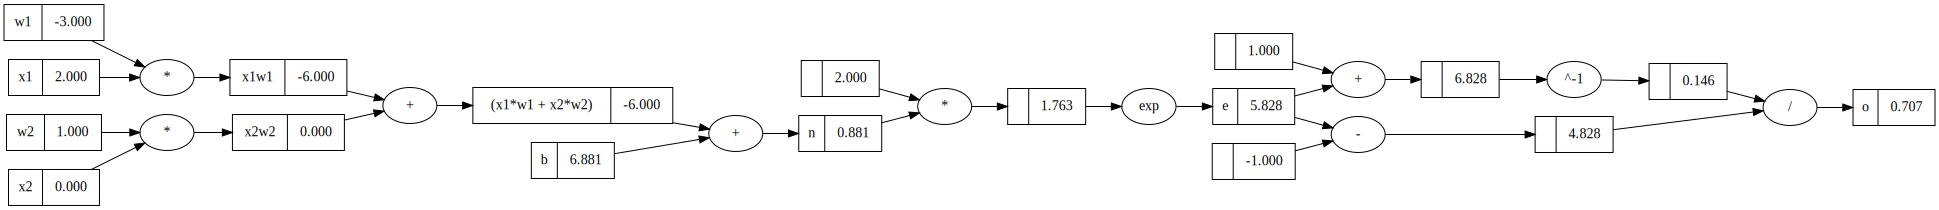

In [51]:
draw_dot(o)

In [52]:
o.backward()

## Neural Network Module

In [53]:
class Neuron(object):
  """
  Implements a single neuron
  """
  def __init__(self, nin):
    self.w = [Scalar(np.random.uniform(-1, 1)) for _ in range(nin)]
    self.b = Scalar(np.random.uniform(-1, 1))    
  def __call__(self, x):
    act = sum((wi*xi for wi,xi in zip(self.w, x)), self.b)
    return act.tanh()

class Layer(object):
  """
  Implements a layer of neurons
  """
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]
    
  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs
  
class MLP(object):
  """
  Implements a multilayer perceptron
  """
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
    
  def __call__(self, x):
    for l in self.layers:
      x = l(x)    
    return x  

In [54]:
x = [2.0, 3.0, -1.0]
m = MLP(3, [4, 4, 1])
o = m(x); o.label='o'

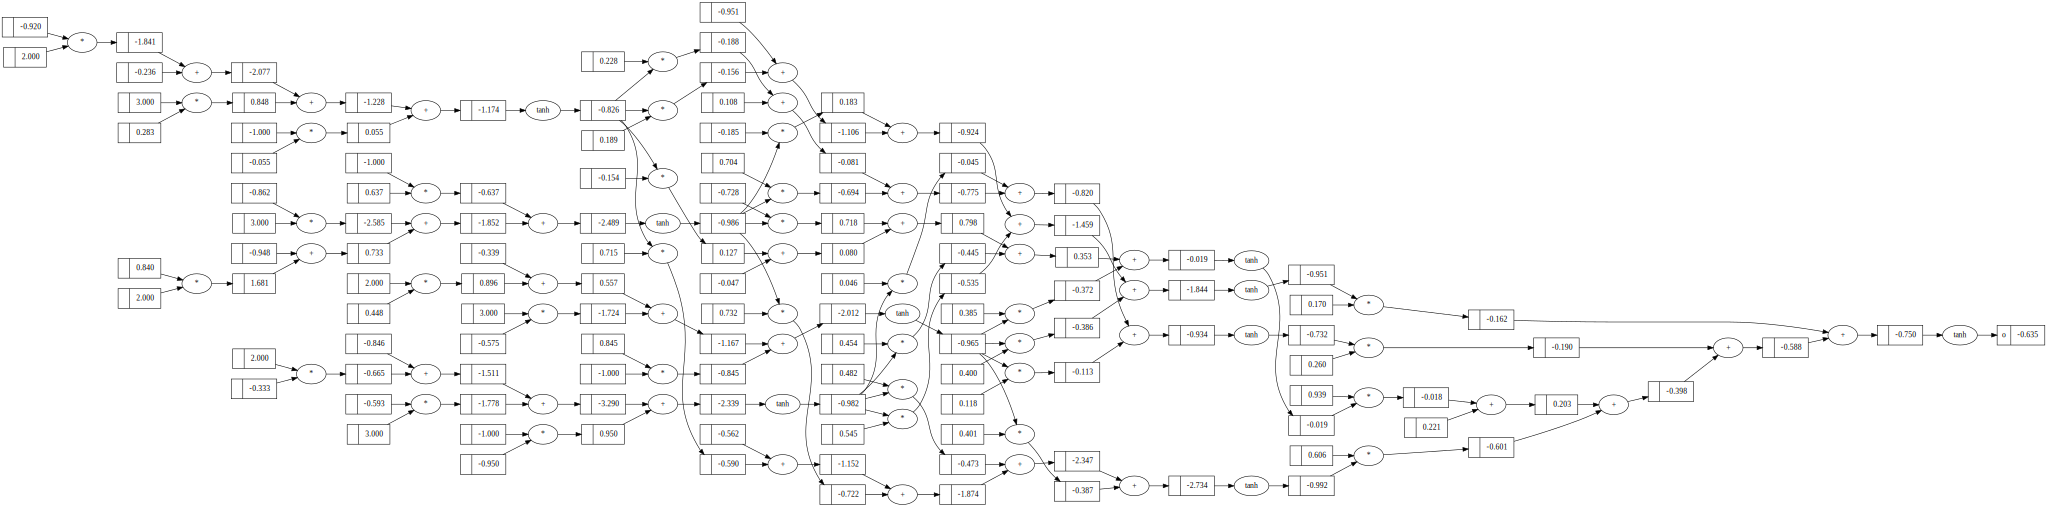

In [55]:
draw_dot(o, show_backprop=False)

## Sample Classification

In [56]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],  
]

ys = [1.0, -1.0, -1.0, 1.0] # targets

In [57]:
n = MLP(3, [4, 4, 1])

In [58]:
ypred = [n(x) for x in xs]
[y.data for y in ypred]

[-0.2863163628644446,
 -0.6593089864241932,
 -0.28001076880734244,
 -0.3627323125532847]

Calculate a single number (scalar) to measure the performance of the NN. This is called the `loss` function. Here we are using the mean squared loss (mse)

In [59]:
loss = sum([(ygt - yout)**2 for ygt, yout in zip(ys, ypred)])/len(ys)
loss

Scalar(data=1.0365260002035852)

In [60]:
loss.backward()

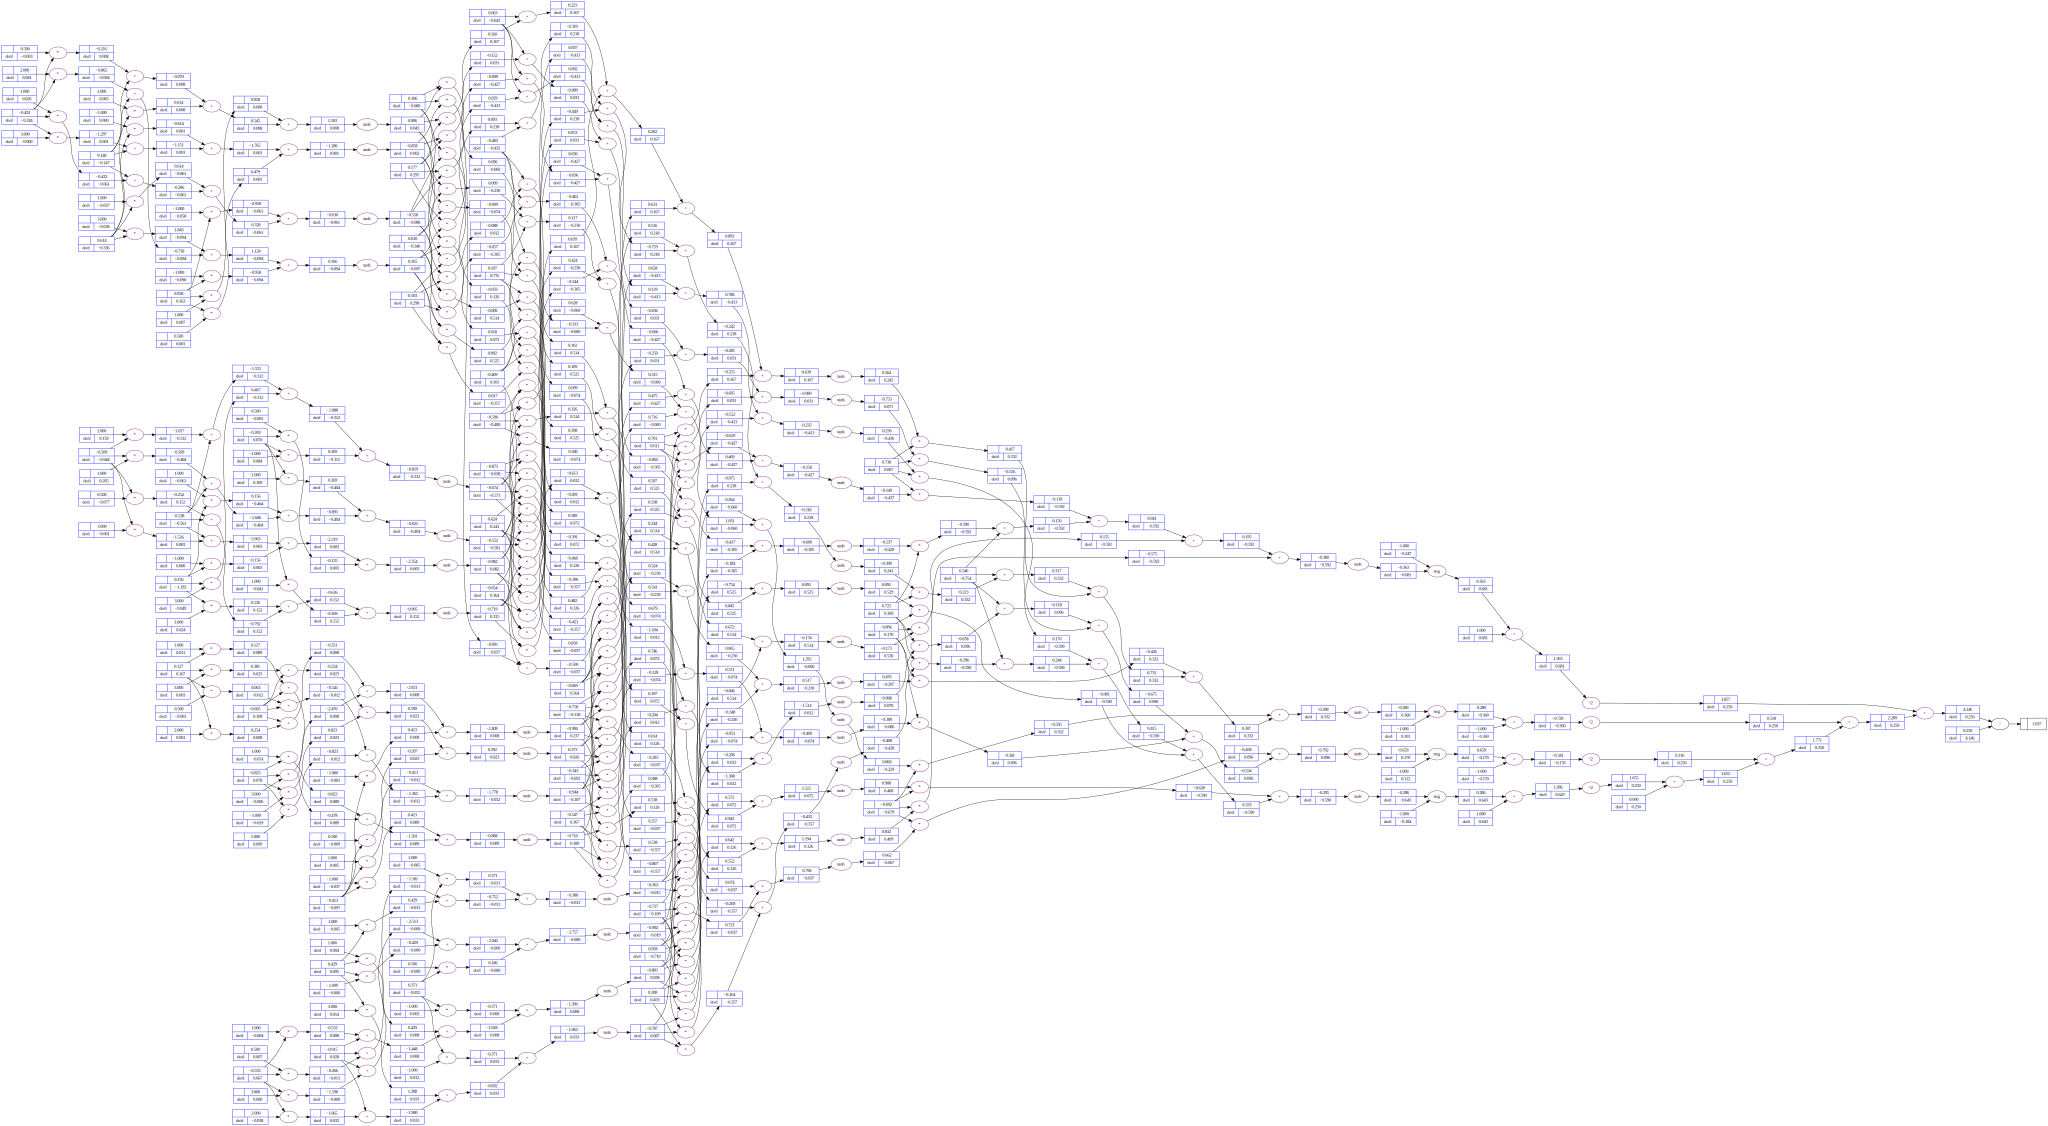

In [61]:
draw_dot(loss, show_backprop=False)

## Extend API with params

In [62]:
class Neuron(object):
  """
  Implements a single neuron
  """
  def __init__(self, nin):
    self.w = [Scalar(np.random.uniform(-1, 1)) for _ in range(nin)]
    self.b = Scalar(np.random.uniform(-1, 1))    
    
  def __call__(self, x):
    act = sum((wi*xi for wi,xi in zip(self.w, x)), self.b)
    return act.tanh()
  
  def parameters(self):
    return self.w + [self.b]

class Layer(object):
  """
  Implements a layer of neurons
  """
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]
    
  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs
  
  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]
  
class MLP(object):
  """
  Implements a multilayer perceptron
  """
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
    
  def __call__(self, x):
    for l in self.layers:
      x = l(x)    
    return x
  
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

Calculate a single number (scalar) to measure the performance of the NN. This is called the `loss` function. Here we are using the mean squared loss (mse)


In [230]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],  
]

ys = [1.0, -1.0, -1.0, 1.0] # targets
n = MLP(3, [4, 4, 1])

In [232]:
for k in range(100): 
  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])/len(ys)
  
  # zero out grad
  for p in n.parameters():
    p.grad = 0.

  # backward
  loss.backward()

  # update
  for p in n.parameters():
    p.data += -1 * p.grad
    
  print(f"Iteration ({k+1}): {loss.data}")

Iteration (1): 0.00014077884960831538
Iteration (2): 0.00013990024782320527
Iteration (3): 0.00013903265450680583
Iteration (4): 0.00013817586227068564
Iteration (5): 0.0001373296689345249
Iteration (6): 0.0001364938773629467
Iteration (7): 0.000135668295308477
Iteration (8): 0.00013485273526032875
Iteration (9): 0.00013404701429882207
Iteration (10): 0.00013325095395511769
Iteration (11): 0.000132464380076101
Iteration (12): 0.00013168712269416474
Iteration (13): 0.00013091901590169095
Iteration (14): 0.00013015989773005422
Iteration (15): 0.00012940961003290254
Iteration (16): 0.00012866799837362512
Iteration (17): 0.0001279349119167369
Iteration (18): 0.00012721020332310734
Iteration (19): 0.00012649372864881545
Iteration (20): 0.0001257853472475059
Iteration (21): 0.00012508492167612152
Iteration (22): 0.00012439231760384234
Iteration (23): 0.0001237074037241364
Iteration (24): 0.0001230300516697766
Iteration (25): 0.00012236013593072597
Iteration (26): 0.00012169753377475223
Itera

In [233]:
ypred

[Scalar(data=0.9910204891161167),
 Scalar(data=-0.9886678278694225),
 Scalar(data=-0.9903653941651086),
 Scalar(data=0.9932268862654642)]